<a href="https://colab.research.google.com/github/jx-dohwan/Deep_Learning_from_Scratch_2_study/blob/main/CH7_RNN%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EB%AC%B8%EC%9E%A5_%EC%83%9D%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CH7_RNN을 사용한 문장 생성
> 이번 장에서는 언어 모델을 사용해 '문장 생성'을 수행한다. 구체적으로는 우선 말뭉치를 사용해 학습한 언어 모델을 이용하여 샐운 문장을 만들어 낸다. 그런 다음 개선된 언어 모델을 이용하여 더 자연스러운 문장을 생성하는 모습을 선보이겠다. 여기까지 해보면 AI로 글을 쓰게 한다라는 개념을 실감할 수 있을 것이다.<br><br> 여기서 멈추지 않고 seq2seq라는 새고운 구조의 싱경망도 다룬다. 시계열에서 시계열로 라는 뜻으로 한 시계열 데이터를 다른 시계열 데이터로 변환하는 것을 말한다. 이 seq2seq는 기계번역, 챗봇, 메일의 자동 답신 등 다양하게 응용될 수 있다.

## 1. 언어 모델을 사용한 문장 생성

### 1) RNN을 사용한 문장 생성의 순서

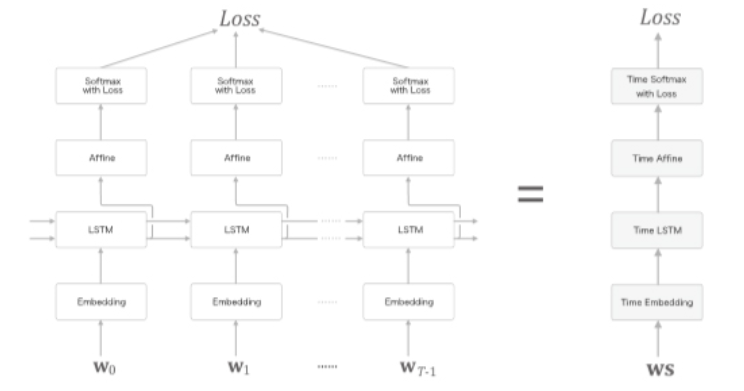

### 2) 문장 생성 구현

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/인공지능/밑시딥2/')
import numpy as np
from common.functions import softmax
from rnnlm import Rnnlm
from better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
  def generate(self, start_id, skip_ids = None, sample_size=100):
    word_ids = [start_id] # 최초로 주는 단어의 ID

    x = start_id 
    while len(word_ids) < sample_size:
      x = np.array(x).reshape(1,1)
      score = self.predict(x)
      p = softmax(score.flatten())

      sampled = np.random.choice(len(p), size=1, p=p)
      if (skip_ids is None) or (sampled not in skip_ids): # skip_id는 단어 ID의 리스트
        x = sampled
        word_ids.append(int(x))

    return 

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/인공지능/밑시딥2/')
from rnnlm_gen import RnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('/content/drive/MyDrive/인공지능/밑시딥2/Rnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids]) # 단어 ID 배열을 문장으로 변환
txt = txt.replace(' <eos>', '.\n')
print(txt)


you think and the amount will take effect those car.
 a machine letter or morning to last week 's confirm again at the bottom of involved rate of meets inflation.
 several attractive computer firms stiff programs by the side of the need spring ca n't be hurt.
 mr. jones succeeded for the giuliani media secretary o'kicki a major candidates for ethiopia who will become their judgment instead of change he is prevent funds with resistance to avoid mining need forced to the economy.
 they 'd want to make the impact of our original daily when it


In [4]:
' '.join(['you','say','goodbye'])

'you say goodbye'

### 3) 더 좋은 문장으로 

## 2. seq2seq
> 시계열 데이터를 다른 시계열 데이터로 변환하는 모델

### 1) seq2seq의 원리
> seq2seq를 Encoder-Decoder 모델이라고도 한다. 여기에서는 2개의 Encoder와 Decoder가 등장한다. 문자 그대로 Encoder는 입력 데이터를 인코딩하고, Decoder는 인코딩된 데이터를 디코딩한다.

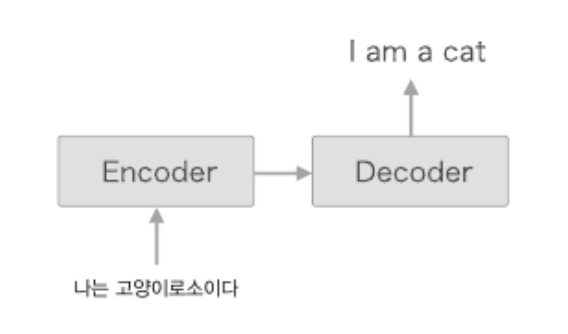

Encoder층을 구성하는 계층

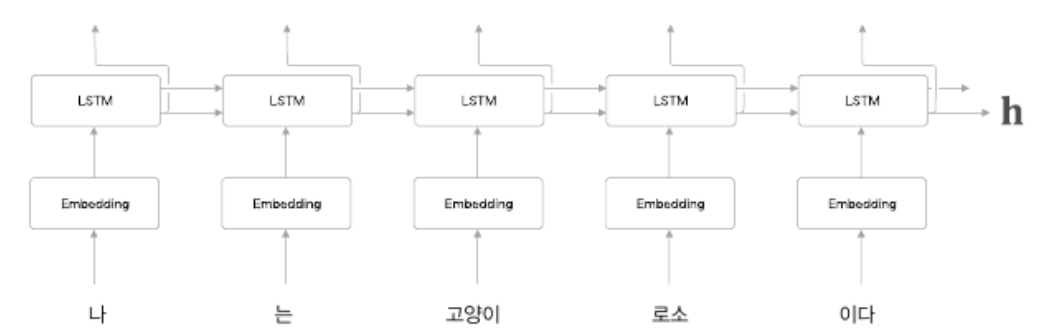

- Encoder는 RNN을 이용해 시계열 데이터 h라는 은닉상태 벡터로 변환한다.
- Encoder가 출력하는 벡터 h는 LSTM계층의 마지막 은닉 상태이다.
- 이 마지막 은닉상태 h에 문장을 번역하는 데 필요한 정보가 인코딩이다.
- 여기서 중요한 점은 LSTM의 은닉상태 h는 고정 길이 벡터라는 것이다.
- 그래서 인코딩한다라함은 결국 임의의 길이의 문장을 고정 길이 벡터로 변환하는 작업이 된다.

Decoder를 구성하는 계층

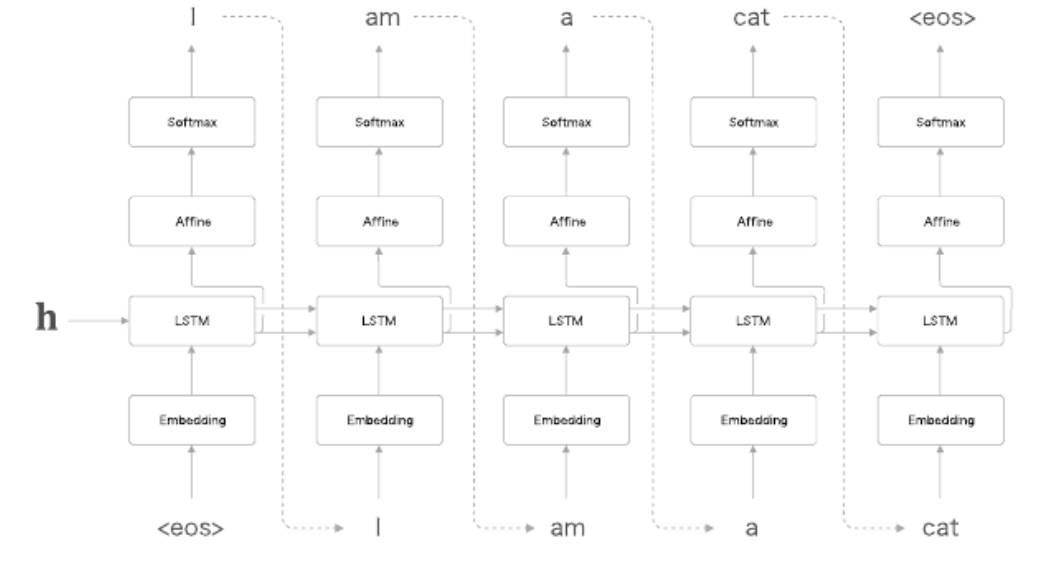

- 앞절의 신경망과 완전히 같은 구성이다. 다른 점이 있다면
- LSTM계층이 벡터 h를 입력받는다는 점이 다르다.
- 참고로, 앞 절의 언어 모델에서는 LSTM계층이 아무것도 받지 않는다.
- 이처ㅇ럼 단 하나의 사소한 차이가 평범한 언어 모델을 번역도 해낼 수 있는 Decoder로 탈바꿈 시킨다.

Decoder와 Encoder를 연결한 계층을 구성

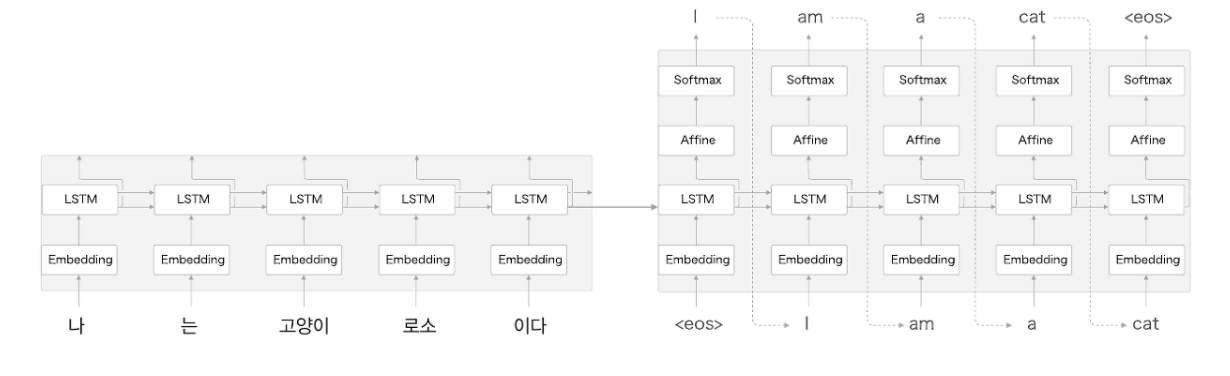

- LSTM 계층의 은닉 상태가 Encoder와 Decoder를 이어주는 가교가 된다.
- 순전파때는 Encoder에서 인코딩된 정보가 LSTM 계층의 은닉상태를 통해 Decoder에 전해진다.
- seq2seq의 역전파때는 이 가교를 통해 기울기가 Decoder로부터 Encoder로 전해진다.

### 2) 시계열 데이터 변환용 장난감 문제
> 지금까지 word2vec이나 언어 모델 등에서 문장을 단어 단위로 분할해왔다. 하지만 문장을 반드시 단어로 분할해야하는 건 아니다. 실제로 이번 문제에서는 단어가 아닌 문자 단위로 분할하려고 한다.

### 3) 가변 길이 시계열 데이터
- 우리는 덧셈을 문자(숫자)의 리스트로써 다루기로 했다. 
- 이때 주의할 점은 덧셈 문장이나 그 대답의 문자 수가 문제마다 다르다는 것이다.
- 덧셈문제에서는 샘플마다 데이터의 시간 방향 크기가 다르다. 이것을 가변 길이 시계열 데이터라고 한다.
- 따라서 신경망 학습 시 미니배치 처리를 하려면 무언가 추가 노력이 필요하다.
- 가변 길이 시계열 데이터를 미니배치로 학습하기 위한 가장 단순한 방법은 패딩을 사용하는 것이다.
- 패딩이란 원래의 데이터에 의미 없는 데이터를 채워 모든 데이터의 길이를 균일하게 맞추는 기법이다.
- 패딩을 덧셈문제에 적용해보면 모든 입력 데이터의 길이를 통일하고, 남는 공간에는 의미 없는 데이터를 채운걸 볼 수 있다.

> 이처럼 패딩을 적용해 데이터 크기를 통일시키면 가변 길이 시계열 데이터도 처리할 수 있다. 그러나 원래는 존해하지 않던 패딩용문자까지 seq2seq가 처리하게 된다. 따라서 패딩을 적용해야 하지만 정확성이 중요하다면 seq2seq에 패딩 전용 처리를 추가해야한다.

### 4) 덧셈 데이터셋(구글 드라이브에서 하니 파일 확장자 오류가 생긴다. 이 부분은 나중에 개선학 지금은 시간을 아끼는게 우선이다. 넘어가라)

In [14]:
import os
os.path.exists('/content/drive/MyDrive/인공지능/밑시딥2/dataset/addition.gdoc')

True

In [15]:
# # coding: utf-8
# import sys
# sys.path.append('/content/drive/MyDrive/인공지능/밑시딥2/dataset')
# import os
# import numpy


# id_to_char = {}
# char_to_id = {}


# def _update_vocab(txt):
#     chars = list(txt)

#     for i, char in enumerate(chars):
#         if char not in char_to_id:
#             tmp_id = len(char_to_id)
#             char_to_id[char] = tmp_id
#             id_to_char[tmp_id] = char


# def load_data(file_name='addition.gdoc', seed=1984):
#     file_path = "/content/drive/MyDrive/인공지능/밑시딥2/dataset" + '/' + file_name
#     print(file_path)

#     if not os.path.exists(file_path):
#         print('No file: %s' % file_name)
#         return None

#     questions, answers = [], []

#     for line in open(file_path, 'r'):
#         idx = line.find('_')
#         questions.append(line[:idx])
#         answers.append(line[idx:-1])

#     # 어휘 사전 생성
#     for i in range(len(questions)):
#         q, a = questions[i], answers[i]
#         _update_vocab(q)
#         _update_vocab(a)

#     # 넘파이 배열 생성
#     x = numpy.zeros((len(questions), len(questions[0])), dtype=numpy.int)
#     t = numpy.zeros((len(questions), len(answers[0])), dtype=numpy.int)

#     for i, sentence in enumerate(questions):
#         x[i] = [char_to_id[c] for c in list(sentence)]
#     for i, sentence in enumerate(answers):
#         t[i] = [char_to_id[c] for c in list(sentence)]

#     # 뒤섞기
#     indices = numpy.arange(len(x))
#     if seed is not None:
#         numpy.random.seed(seed)
#     numpy.random.shuffle(indices)
#     x = x[indices]
#     t = t[indices]

#     # 검증 데이터셋으로 10% 할당
#     split_at = len(x) - len(x) // 10
#     (x_train, x_test) = x[:split_at], x[split_at:]
#     (t_train, t_test) = t[:split_at], t[split_at:]

#     return (x_train, t_train), (x_test, t_test)


# def get_vocab():
#     return char_to_id, id_to_char


In [16]:
# print(load_data('addition.gdoc', seed=1984))

/content/drive/MyDrive/인공지능/밑시딥2/dataset/addition.gdoc


OSError: ignored

In [8]:
# os.path.dirname(os.path.abspath(__file__)) 절대 경로 찾기 안돼서 실제 내 경로를 넣음

In [9]:
# print(load_data('addition.txt', seed=1984)) 계속 None 떠서 뭐가 문제인지 파악하니 확장자가 txt가 아닌 gdoc(구글 도큐먼트 어쩌구인듯)으로 되어 있음

In [10]:
# # coding: utf-8
# import sys
# sys.path.append('/content/drive/MyDrive/인공지능/밑시딥2/')
# from dataset import sequence


# (x_train, t_train), (x_test, t_test) = \
#     sequence.load_data('addition.gdoc', seed=1984)
# char_to_id, id_to_char = sequence.get_vocab()

# print(x_train.shape, t_train.shape)
# print(x_test.shape, t_test.shape)
# # (45000, 7) (45000, 5)
# # (5000, 7) (5000, 5)

# print(x_train[0])
# print(t_train[0])
# # [ 3  0  2  0  0 11  5]
# # [ 6  0 11  7  5]

# print(''.join([id_to_char[c] for c in x_train[0]]))
# print(''.join([id_to_char[c] for c in t_train[0]]))
# # 71+118
# # _189


/content/drive/MyDrive/인공지능/밑시딥2/dataset/addition.gdoc
No file: addition.gdoc


TypeError: ignored

## 3. seq2seq 구현
> seq2seq는 2개의 RNN을 연결한 신경망이다. 먼저 두 RNN을 Encoder 클래스와 Decoder 클래스고 구현하겠다. 그런 다음 두 클래스를 연결하는 seq2seq 클래스를 구현하는 흐름으로 진행하보자

### 1) Encoder클래스
> Encoder 클래스는 문자열을 받아 벡터 h로 변환한다. 그리고 여기에 LSTM 계층을 이용해 볼 것이다. 

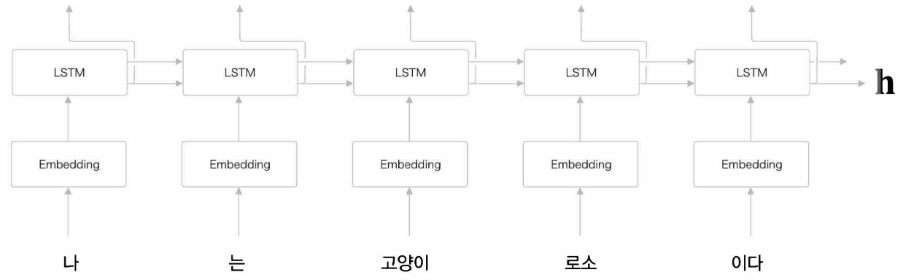

- Embedding 계층에서는 문자(정확하게는 문자 ID)를 문자 벡터로 변환한다.
- 그리고 이 문자 벡터가 LStm계층으로 입력된다.
- LSTM 계층은 오른쪽으로는 은닉 상태의 셀을 출력하고
- 위쪽으로는 은닉상태만 출력한다.
- 이 구성에서 더 위에는 다른 계층이 없으니 LSTM 게층의 위쪽 출력은 폐기 된다.
- Encoder에서는 마지막 문자를 처리한 후 LSTM게층의 은닉 상태 h를 출력한다.
- 그리고 이 은닉상태 h가 Decoder로 전달된다.
- 그런데 우리는 시간 방향을 한꺼번에 처리하는 계층을 Time LSTM계층이나 Time Embedding 계층으루 구현했다.


In [19]:
class Encoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size # vocab_size : 어휘수(문자의 종류)
    rn = np.random.randn

    embed_W = (rn(V,D)/100).astype('f')
    lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)#TimeLSTM 계층이 상태를 유지하지 않는다.

    self.params = self.embed.params + self.lstm.params # 가중치 매개변수 저장
    self.grads = self.embed + self.lstm.grads # 기울기 인스턴스 변수 저장
    self.hs = None

  # 순전파에서는 Time Embedding 계층과 Time LSTM 계층의 forward() 메서드를 호출한다.
  # 그리고 Time LSTM 계층의 마지막 시각의 은닉 상태만 추출해
  # 그 값을 Encoder의 forward() 메서드의 출력을 반환한다.  
  def forward(self, xs):
    xs = self.embed.forward(xs)
    hs = self.lstm.forward(xs)
    self.hs = hs
    return hs[:,-1,:]

  # 역전파에서는 LSTM계층의 마지막 은닉 상태에 대한 기울기가 dh 인수로 전해진다.
  # 이 dh는 Decoder가 전해주느 기울기이다.
  # 역전파 구현에서는 원소가 모두 0인 텐서 dhs를 생성하고 dh를 dhs의 해당 위치에 할당한다.
  # 그 다음은 Time LSTM 계층과 Time Embedding 계층의 backward() 메서드를 호출한다.
  def backward(self, dh):
    dhs = np.zeros_like(self.hs)
    dhs[:,-1,:]= dh

    dout = self.lstm.backward(dhs)
    dout = self.embed.backward(dout)
    return dout

### 2) Decoder 클래스
> Decoder 클래스는 Encoder 클래스가 출력한 h를 방아 목적으로 하는 다른 문자열을 출력한다. Decodersms RNN으로 구현할 수 있다. Encoder과 마찬가지로 LSTM계층을 사용하면 되며, 이때 Decoder의 계층 구성이 된다 그림으로 보면 아래와 같다.

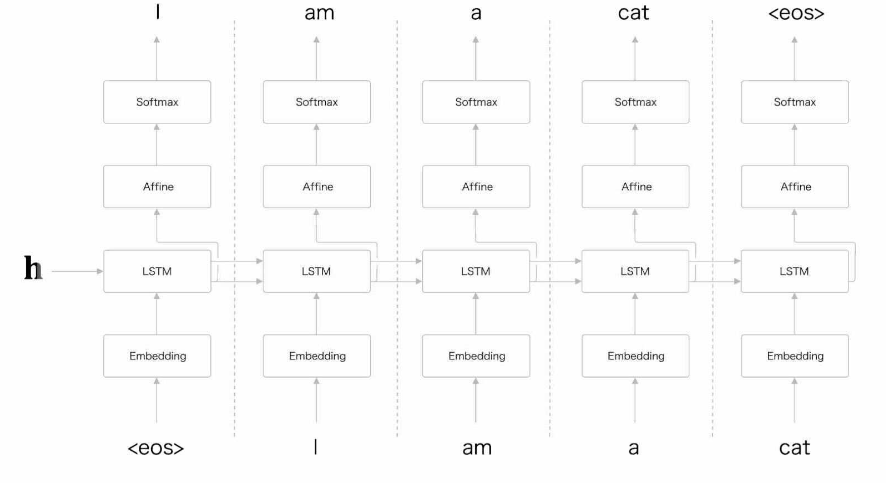



- 이번에는 Softmax 계층을 사용하지 않고, Affine 계층이 출력하는 점수가 가장 큰 문자 ID를 선택한다.
- 여기서 설명한 것 처럼 Decoder에서는 학습시와 생성 시에 Softmax 계층을 다르게 취급한다.
- 그러니 Softmax with Loss 계층은 이후에 구현하는 Seq2seq 클래스에서 처리하기로 하고
- Decoder클래스는 Time Softmax with Loss 계층의 앞까지만 담당하기로 한다.

> Decoder 클래스는 Time Embedding, Time LSTM, Time Affine의 3가지 계층으로 구성된다.

In [21]:
class Decoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V,D)/100).astype('f')
    lstm_Wx = (rn(D,4*H)/np.sart(D)).astype('f')
    lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.affine = TimeAffine(affine_W, affine_b)
    self.params, self.grads=[],[]
    for layer in (self.embed, self.lstm, self.affine):
      self.grads += layer.params
      self.grads += layer.grads

  def forward(self, xs, h):
    self.lstm.set_state(h)

    out = self.embed.forward(xs)
    out = self.lstm.forward(out)
    score = self.affine.forward(out)
    return score

  # 위쪽의 Softmax with Loss 계층으로부터 기울기 dscore를 받아 Time Affine 계층
  # Time LSTM 계층, Time Embedding 계응 순서로 전파시킨다.
  # 이때 Time LSTM 계층의 시간 방향으로의 기울기는 TimeLSTM 클래스의 인스턴스 변수 dh에 저장되어 있다.
  # 그래서 이 시간 방향의 기울기 dh를 꺼내서 Decoder 클래스의 backward()의 출력으로 반환한다.
  def backward(self, dscore):
    dout = self.affine.backward(dscore)
    dout = self.lstm.backward(dout)
    dout = self.embed.backward(dout)
    dh = self.lstm.dh
    return dh

  # 인수를 3개 받는다. 차레로 Encoder로부터 은닉상태인h, 최초로 주어지는 문자 ID인 start_id, 생성하는 문자수인 sample_size이다.
  # 여기에서 문자를 1개씩 주고, Affine 게층이 출력하는 점수가 가장 큰 문자 ID를 선택하는 작업을 반복한다.
  # 이상이 Decoder 클래스의 구현 전부이다.
  def generate(self, h, start_id, sample_size):
    sampled = []
    sample_id = start_id
    self.lstm.set_state(h)

    for _ in range(sample_size):
      x = np.array(sample_id.reshape(1,1))
      out = self.embed.forward(x)
      out = self.lstm.forward(out)
      score = self.affine.forward(out)

      sample_id = np.argmax(score.flatten())
      sampled.append(int(sample_id))
    
    return sampled


### 3) Seq2seq 클래스
> 이 클래스가 하는 일은 Encoder 클래스와 Decoder 클래스를 연결하고, Time Softmax with Loss 계층을 이용해 손실을 계산하는 것이 전부이다.

In [23]:
# coding: utf-8
import sys
sys.path.append('/content/drive/MyDrive/인공지능/밑시딥2')
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled
